### Install/Import libraries
We'll be using numpy, pandas, and xarray for preprocessing, matplotlib for vizualization, tensorflow to construct the model, and the last two are dependencies needed to open the dataset.

In [54]:
! pip install numpy pandas matplotlib xarray tensorflow netcdf4 xarray[io]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from tensorflow import keras
import os

In [4]:
filename = 'c:/Users/sguti/preprocessing/Scorched Earth Data/Mongolia_2D_ERA5_2010_2024.nc'
# fullpath = os.path.join(os.getcwd(), 'Scorched Earth Data', filename)
# dataset = xr.open_dataset(fullpath)
dataset = xr.open_dataset(filename)
dataset

<xarray.Dataset>
Dimensions:    (time: 5373, step: 24, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 47.8 47.7 47.6 47.5 47.4
  * longitude  (longitude) float64 106.4 106.5 106.6 106.7 106.8
  * step       (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * time       (time) datetime64[ns] 2009-12-31 2010-01-01 ... 2024-03-31
Data variables:
    d2m        (time, step, latitude, longitude) float32 ...
    sp         (time, step, latitude, longitude) float32 ...
    t2m        (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 19 16:26:46 2024: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

### Preprocessing

In [5]:
clean_ds = dataset.dropna(dim="time", how="any")

In [6]:
days = clean_ds.coords['time'].shape[0]

rows = days * 24
hourly_t2m_ds = np.empty(shape=(rows))
hourly_d2m_ds = np.empty(shape=(rows))
hourly_sp_ds = np.empty(shape=(rows))

row = 0
for x in range(days):
	for y in range(24):
		hourly_t2m_ds[row] = clean_ds["t2m"][x, y, 2, 2]
		hourly_d2m_ds[row] = clean_ds["d2m"][x, y, 2, 2]
		hourly_sp_ds[row] = clean_ds["sp"][x, y, 2, 2]

		row += 1

In [7]:
clean_ds.coords["step"] = ["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00","08:00:00","09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00","18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00","23:00:00"]
dateTimeCoords = []
for date in clean_ds.coords["time"].values:
	for time in clean_ds.coords["step"].values:
		dateTime = str(date)[:11] + time
		dateTimeCoords.append(dateTime)

In [8]:
clean_hourly_ds = xr.Dataset(
    data_vars=dict(
        t2m=(["datetime"], hourly_t2m_ds),
        d2m=(["datetime"], hourly_d2m_ds),
		sp=(["datetime"], hourly_sp_ds),
    ),
    coords=dict(
        datetime=("datetime", np.array(dateTimeCoords, dtype='datetime64[h]'))
    ),
    attrs=dict(description="Hourly data from 2010-01-01 to 2024-03-30 at 47.6N 106.6E Ulaanbaatar, Mongolia."),
)

C:\Users\sguti\AppData\Local\Temp\ipykernel_24316\2520399145.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  clean_hourly_ds = xr.Dataset(


In [9]:
clean_hourly_ds["t2m"] = 9/5 * (clean_hourly_ds["t2m"] - 273.15) + 32
clean_hourly_ds["d2m"] = 9/5 * (clean_hourly_ds["d2m"] - 273.15) + 32
clean_hourly_ds["sp"] /= 100

### Feature Engineering

In [10]:
lag_time = 24
lead_time = 1
window = lag_time + lead_time

In [11]:
def make_supervised(dataset, lag_time, lead_time, dataset_size, features=1):
	### make_supervised(): Creates overlapping samples ###

	window = lag_time + lead_time 
	rows = dataset_size - window

	if features == 1:
		inputs = np.empty((rows, lag_time))
	else:
		inputs = np.empty((rows, lag_time, features))

	outputs = np.empty((rows, lead_time))

	for i in range(rows):
		x = dataset.iloc[i:(i+lag_time)]

		if features == 1:
			y = dataset.iloc[i:(i+lead_time)]
			inputs[i, :] = x
			outputs[i, :] = y
		else:
			y = dataset.iloc[i:(i+lead_time)]["t2m"]
			inputs[i, :, :] = x
			outputs[i, :] = y

	return inputs, outputs

In [12]:
clean_hourly_df = clean_hourly_ds.to_dataframe()
clean_hourly_df.head()

,t2m,d2m,sp
datetime,,,
2010-01-01 00:00:00,-10.466069,-15.221062,850.039375
2010-01-01 01:00:00,-8.896535,-13.519115,850.758750
2010-01-01 02:00:00,-4.705443,-11.755672,851.107500
2010-01-01 03:00:00,-1.632595,-10.515013,851.286875
2010-01-01 04:00:00,1.262605,-8.389434,851.213750


### Training, Validation, and Testing Sets

In [13]:
train_df = clean_hourly_df.loc["2010-01-01T00:00:00.000000000":"2020-12-31T23:00:00.000000000"]
valid_df = clean_hourly_df.loc["2021-01-01T00:00:00.000000000":"2023-12-31T23:00:00.000000000"]
test_df = clean_hourly_df.loc["2024-01-01T00:00:00.000000000":"2024-03-31T23:00:00.000000000"]

In [14]:
X_train, y_train = make_supervised(train_df["t2m"], lag_time, lead_time, len(train_df["t2m"]))
X_valid, y_valid = make_supervised(valid_df["t2m"], lag_time, lead_time, len(valid_df["t2m"]))
X_test, y_test = make_supervised(test_df["t2m"], lag_time, lead_time, len(test_df["t2m"]))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(93191, 24)
(93191, 1)
(25391, 24)
(25391, 1)
(2087, 24)
(2087, 1)


In [15]:
X_train_min = X_train.min()
X_train_max = X_train.max()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_valid = (X_valid - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

## Modeling

### Baseline Model

In [16]:
def baseline_model(X_test):
	predictions = []
	for i in range(X_test.shape[0]):
		predictions.append(X_test[i][-1])
	return np.array(predictions)

In [17]:
norm_predictions = baseline_model(X_test)
# Revert to original scale
predictions = (X_train_max - X_train_min) * norm_predictions + X_train_min

mse = 0
n = y_test.shape[0]
for i in range(n):
	mse += np.square((y_test[i] - predictions[i]))
mse /= n
print(f'Mean Square Error: {mse[0]:.3f}')

Mean Square Error: 95.207


### Univariate LSTM Model

An Long Short-Term Mwmory network is commonly used for forecasting. Typically used for natural language processing, but they can also be used for any time-series forecast context. The LSTM is comprised of units that contain an input gate, an output gate, and a forget gate. This structure helps with retaining useful information while discarding useless information over long period of time. The univariate model will serve as a baseline for more complicated LSTM models. It will only take the 2 meter temperature data to predict the future temperature.

TensorFlow has the Keras API that makes it easy to build deep learning models.

In [127]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout

The batch size is the number of training samples before the model is updated. A commonly used batch size is 32, but tests will have to be made to find the optimal batch size.

The LSTM will take the previous 24 hours as input and then return the temperature at the last time step.

In [19]:
batch_size = 32
input_length = lag_time
variables = 1

uni_lstm_model = Sequential()
uni_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
uni_lstm_model.add(LSTM(units=32, activation='relu', return_sequences=False))
uni_lstm_model.add(Dense(1))

The compile_and_fit function will set the loss, optimizer, any metrics, and train the model. The function has an option to interrupt the training early if the model's performance is not improving after a certain amount of epochs.

In [20]:
MAX_EPOCHS = 10

def compile_and_fit(model, X_train, y_train, X_valid, y_valid, patience=5):
  # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
	# 											patience=patience,
	# 											mode='min')

  model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(),
                metrics=[keras.metrics.MeanAbsoluteError()])

  print(model.summary())
  
  history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                      validation_data=(X_valid, y_valid))
                      # callbacks=[early_stopping])
  return history

In [21]:
history = compile_and_fit(uni_lstm_model, X_train, y_train, X_valid, y_valid)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (32, 32)               │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 167.5003 - mean_absolute_error: 6.3461 - val_loss: 0.4659 - val_mean_absolute_error: 0.4958
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.0812 - mean_absolute_error: 0.7940 - val_loss: 0.3531 - val_mean_absolute_error: 0.4593
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.8338 - mean_absolute_error: 0.6919 - val_loss: 0.3170 - val_mean_absolute_error: 0.4515
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.5264 - mean_absolute_error: 0.5610 - val_loss: 0.3496 - val_mean_absolute_error: 0.4651
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.4986 - mean_absolute_error: 0.5450 - val_loss: 0.2273 - val_mean_absolute_error: 0.3744
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.3592 - mean_absolute_error: 0.4616 - val_loss: 0.1434 - val_mean_absolute_error: 0.2928
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.3826 - mea

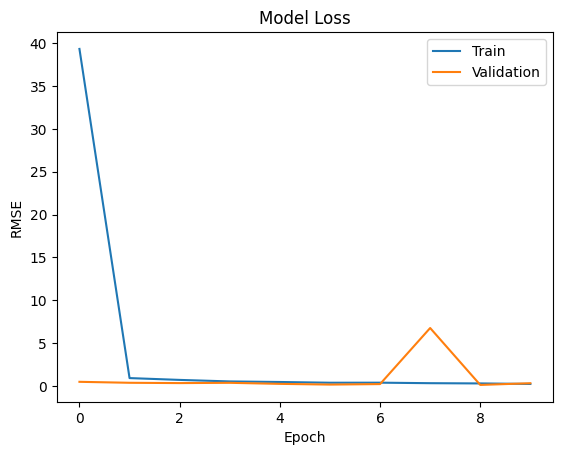

In [22]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [23]:
predictions = uni_lstm_model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


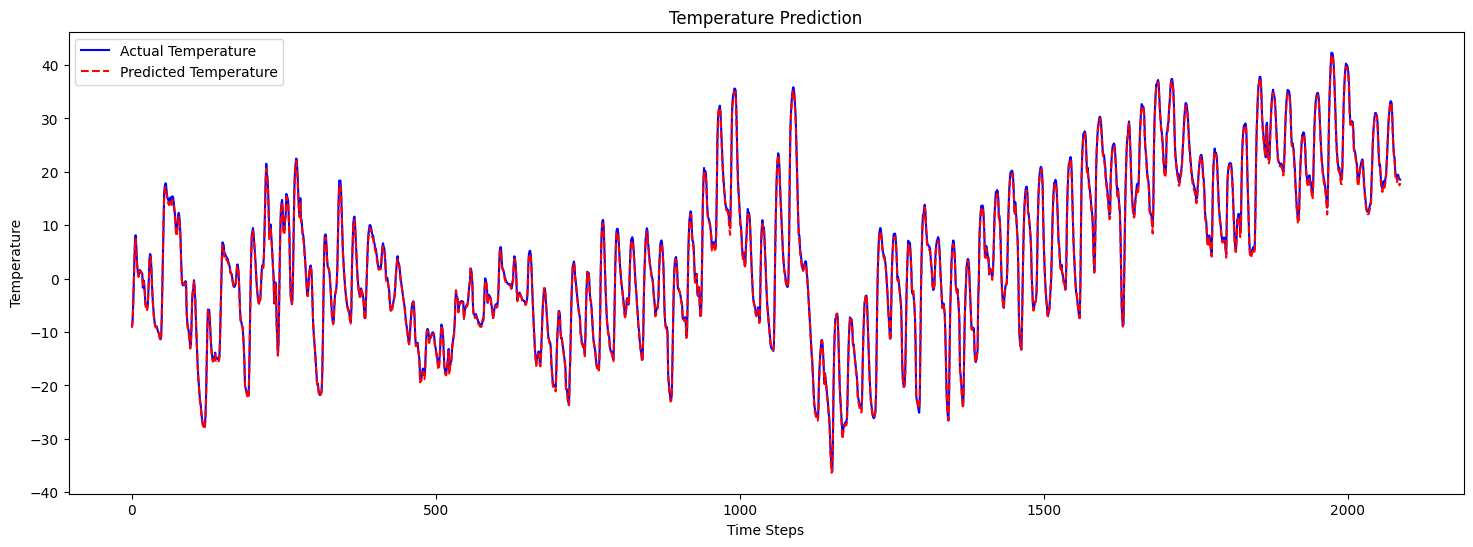

In [24]:
plt.figure(figsize=(18,6))
plt.plot(y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

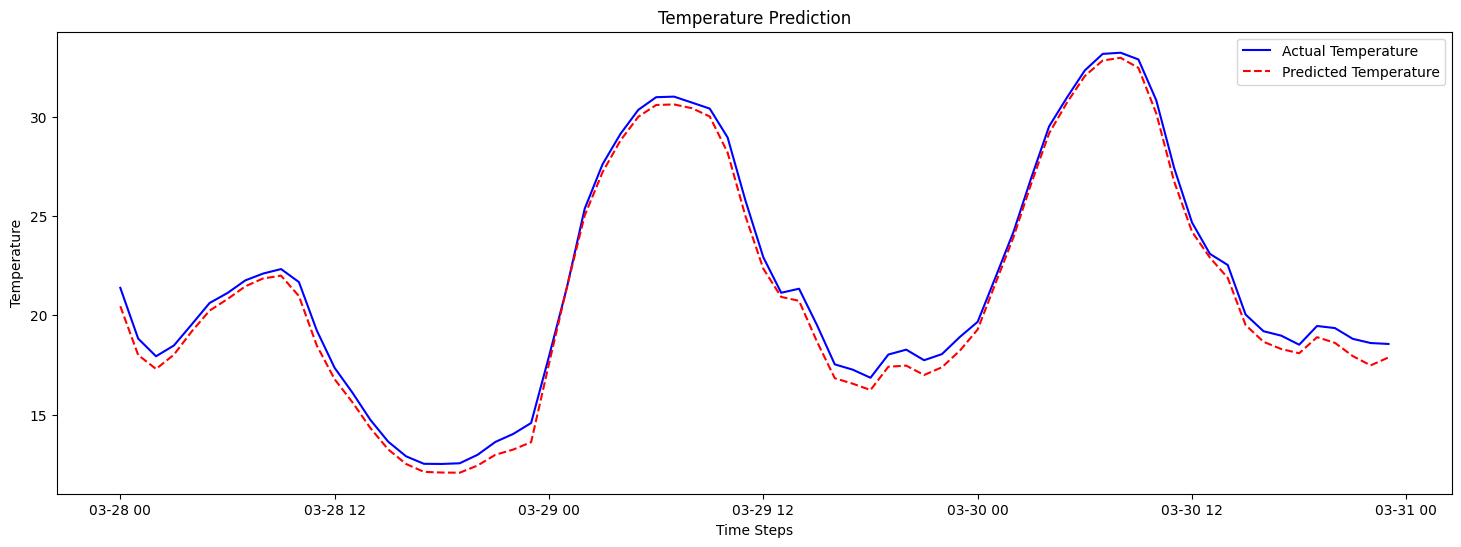

In [25]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Multivariate LSTM Model

In [26]:
multi_train_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2010-01-01T00:00:00':'2020-12-31T23:00:00']
multi_valid_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2021-01-01T00:00:00':'2023-12-31T23:00:00']
multi_test_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2024-01-01T00:00:00':'2024-03-31T23:00:00']

In [27]:
print(multi_train_df.shape)
print(multi_valid_df.shape)
print(multi_test_df.shape)

(93216, 3)
(25416, 3)
(2112, 3)


In [28]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [29]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [30]:
batch_size = 32
input_length = lag_time
variables = 3

multi_lstm_model = Sequential()
multi_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model.add(Dense(1))

In [31]:
multi_history = compile_and_fit(multi_lstm_model, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (32, 32)               │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 252.0125 - mean_absolute_error: 9.9947 - val_loss: 11.5056 - val_mean_absolute_error: 2.6049
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 11.5345 - mean_absolute_error: 2.6276 - val_loss: 5.3156 - val_mean_absolute_error: 1.7815
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 7.4520 - mean_absolute_error: 2.1225 - val_loss: 3.9726 - val_mean_absolute_error: 1.5497
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 4.7165 - mean_absolute_error: 1.6823 - val_loss: 2.0864 - val_mean_absolute_error: 1.0264
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2.9719 - mean_absolute_error: 1.3473 - val_loss: 6.2881 - val_mean_absolute_error: 2.1556
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2.3447 - mean_absolute_error: 1.2045 - val_loss: 1.4200 - val_mean_absolute_error: 0.9352
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.9930 - m

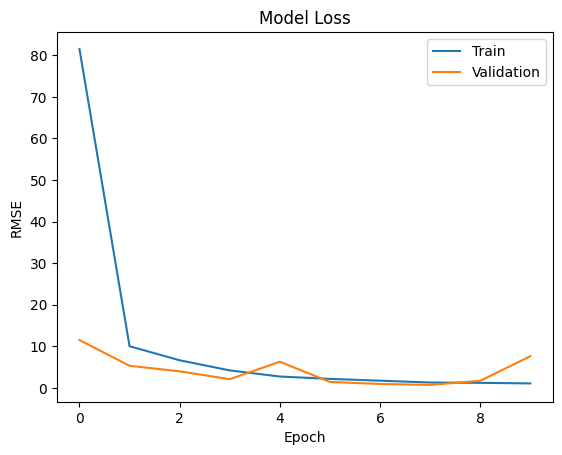

In [32]:
plt.plot(multi_history.history['loss'], label='Train')
plt.plot(multi_history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [33]:
multi_predictions = multi_lstm_model.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


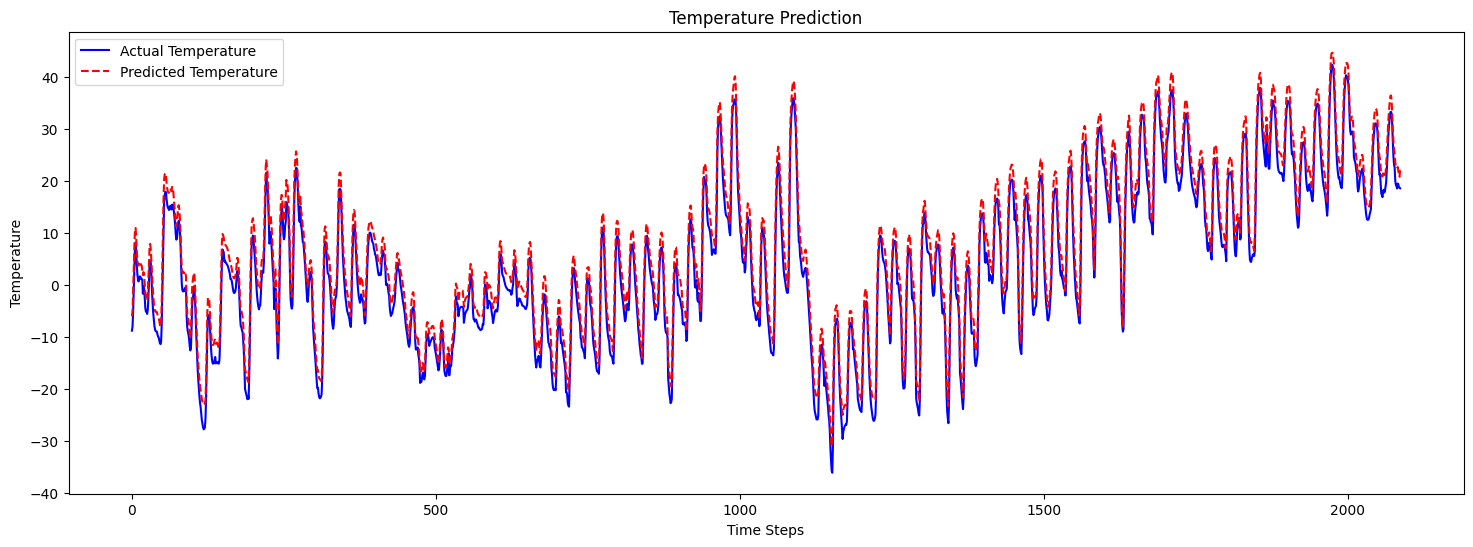

In [34]:
plt.figure(figsize=(18,6))
plt.plot(multi_y_test, color='blue', label='Actual Temperature')
plt.plot(multi_predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

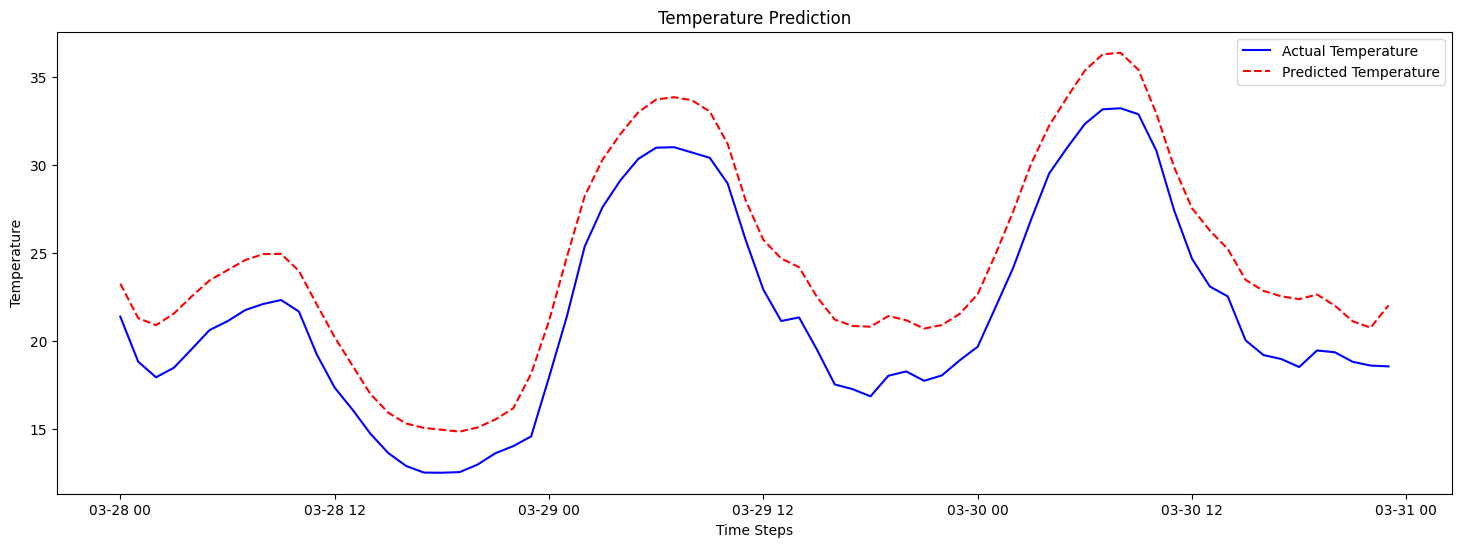

In [35]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], multi_y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Univariate and Multivariate Model Comparison

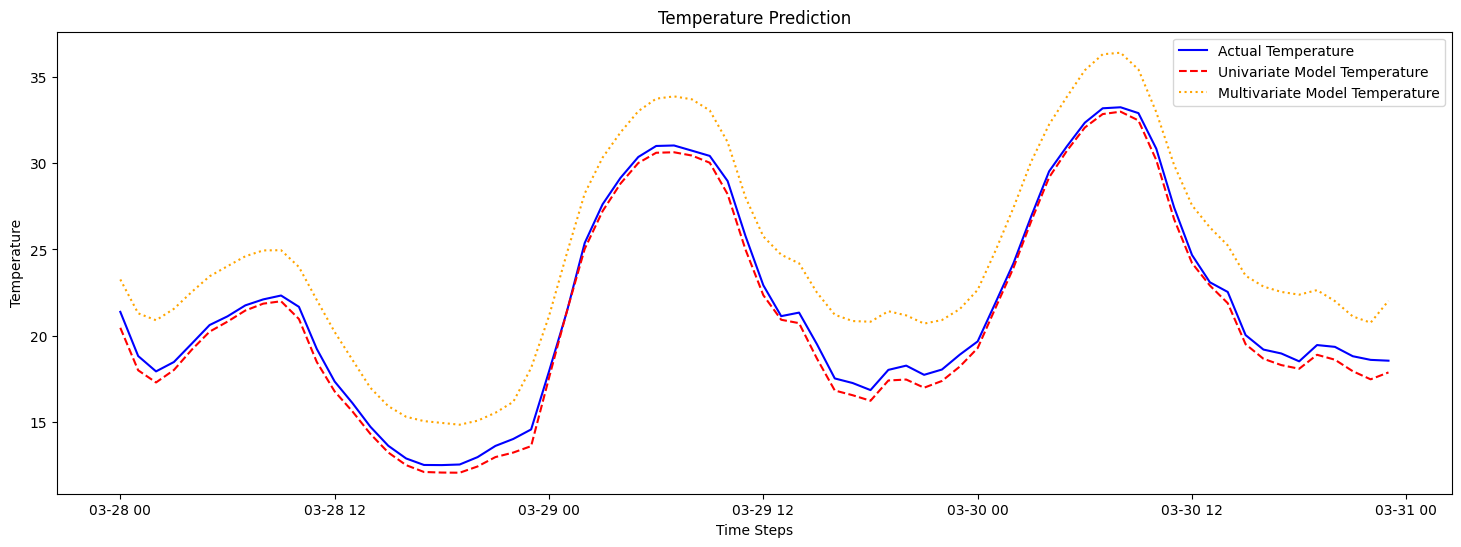

In [36]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Univariate Model Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='orange', linestyle='dotted', label='Multivariate Model Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [37]:
print("Univariate Loss", history.history['loss'][-1])
print("Univariate Validation Loss", history.history['val_loss'][-1])
print("Multivariate Loss", multi_history.history['loss'][-1])
print("Multivariate Validation Loss", multi_history.history['val_loss'][-1])

Univariate Loss 0.21580083668231964
Univariate Validation Loss 0.3008272051811218
Multivariate Loss 1.0700148344039917
Multivariate Validation Loss 7.6210503578186035


While the multivariate LSTM model's training loss is lower than the univariate, it performed better on the validation set. Yet, the multivariate LSTM model is marginally better. To further decrease the loss, it would be more productive to do feature engineering and feature selection rather than adding more complexity to the model.

In [277]:
lag_time = 24
lead_time = 2
window = lag_time + lead_time

In [278]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [279]:
print(multi_X_train.shape)
print(multi_y_train.shape)

(93190, 24, 3)
(93190, 2)


In [280]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [281]:
multi_lstm_model_2 = Sequential()
multi_lstm_model_2.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_2.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_2.add(Dense(lead_time))

In [282]:
multi_step_history_2 = compile_and_fit(multi_lstm_model_2, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (32, 32)               │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,674 (18.26 KB)

 Trainable params: 4,674 (18.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 242.7844 - mean_absolute_error: 9.7847 - val_loss: 8.4603 - val_mean_absolute_error: 2.1966
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 7.6575 - mean_absolute_error: 2.0733 - val_loss: 2.7233 - val_mean_absolute_error: 1.2084
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 3.2250 - mean_absolute_error: 1.3462 - val_loss: 5.5825 - val_mean_absolute_error: 2.0664
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.6156 - mean_absolute_error: 1.2270 - val_loss: 1.9659 - val_mean_absolute_error: 1.0482
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 2.1552 - mean_absolute_error: 1.1165 - val_loss: 1.9701 - val_mean_absolute_error: 1.0899
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 1.8697 - mean_absolute_error: 1.0473 - val_loss: 2.9258 - val_mean_absolute_error: 1.3692
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 1.3420 - mea

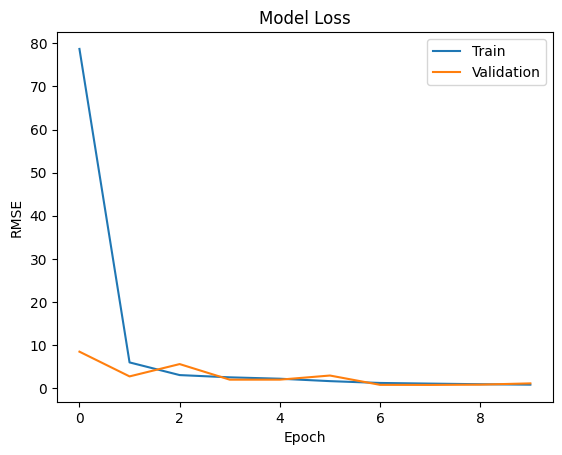

In [283]:
plt.plot(multi_step_history_2.history['loss'], label='Train')
plt.plot(multi_step_history_2.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [284]:
multi_predictions_2 = multi_lstm_model_2.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [347]:
lag_time = 24
lead_time = 6
window = lag_time + lead_time

In [348]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [349]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [350]:
multi_lstm_model_24hr_6lead = Sequential()
multi_lstm_model_24hr_6lead.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_24hr_6lead.add(LSTM(units=64, activation='relu', return_sequences=True))
multi_lstm_model_24hr_6lead.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_24hr_6lead.add(Dense(lead_time))

In [351]:
multi_step_history_24hr_6lead = compile_and_fit(multi_lstm_model_24hr_6lead, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (32, 24, 64)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (32, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,022 (117.27 KB)

 Trainable params: 30,022 (117.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - loss: 182.4341 - mean_absolute_error: 8.1143 - val_loss: 27.6356 - val_mean_absolute_error: 4.2646
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 16.7974 - mean_absolute_error: 3.1083 - val_loss: 15.4851 - val_mean_absolute_error: 2.9222
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - loss: 15.9090 - mean_absolute_error: 2.9866 - val_loss: 13.8289 - val_mean_absolute_error: 2.7732
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 13.4649 - mean_absolute_error: 2.6890 - val_loss: 9.1466 - val_mean_absolute_error: 2.4592
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - loss: 4.1885 - mean_absolute_error: 1.5560 - val_loss: 2.8694 - val_mean_absolute_error: 1.2918
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 2.7624 - mean_absolute_error: 1.2615 - val_loss: 2.3453 - val_mean_absolute_error: 1.1477
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss:

In [352]:
multi_predictions_24hr_6lead = multi_lstm_model_24hr_6lead.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


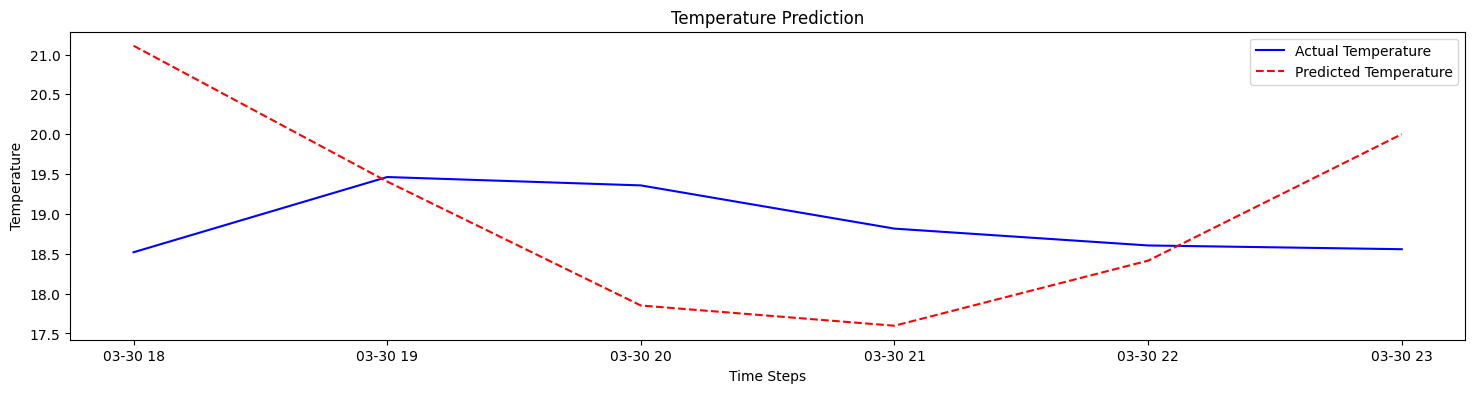

In [354]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-6:], multi_y_test[-1], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-6:], multi_predictions_24hr_6lead[-1], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

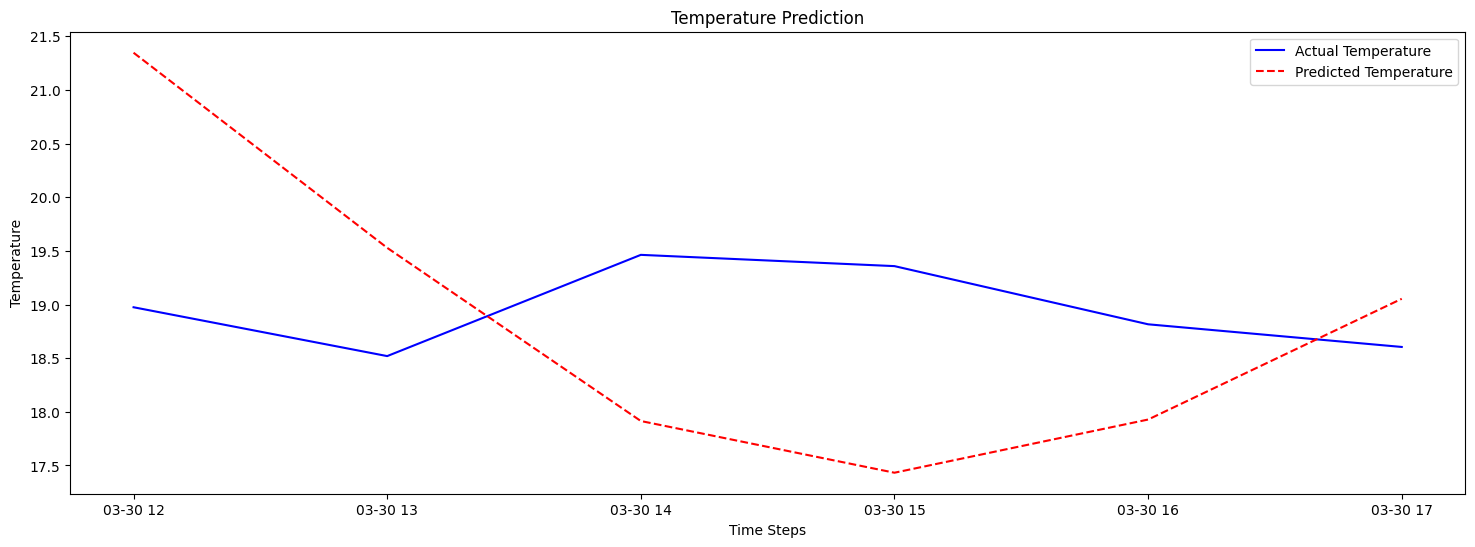

In [355]:
plt.figure(figsize=(18,6))

plt.plot(test_df.index[-12:-6], multi_y_test[-2], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-12:-6], multi_predictions_24hr_6lead[-2], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [356]:
lag_time = 48
lead_time = 6
window = lag_time + lead_time

In [357]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [358]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [359]:
multi_lstm_model_48hr_6lead = Sequential()
multi_lstm_model_48hr_6lead.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_48hr_6lead.add(LSTM(units=64, activation='relu', return_sequences=True))
multi_lstm_model_48hr_6lead.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_48hr_6lead.add(Dense(lead_time))

In [360]:
multi_step_history_48hr_6lead = compile_and_fit(multi_lstm_model_48hr_6lead, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (32, 24, 64)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (32, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,022 (117.27 KB)

 Trainable params: 30,022 (117.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 94s 31ms/step - loss: 1101.4979 - mean_absolute_error: 12.3819 - val_loss: 15.6604 - val_mean_absolute_error: 2.9594
Epoch 2/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 16.1701 - mean_absolute_error: 3.0084 - val_loss: 15.1127 - val_mean_absolute_error: 2.8988
Epoch 3/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 91s 31ms/step - loss: 14.9416 - mean_absolute_error: 2.8506 - val_loss: 14.4313 - val_mean_absolute_error: 2.7918
Epoch 4/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 91s 31ms/step - loss: 14.8686 - mean_absolute_error: 2.8438 - val_loss: 13.5659 - val_mean_absolute_error: 2.7057
Epoch 5/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - loss: 12.1876 - mean_absolute_error: 2.5753 - val_loss: 5.9192 - val_mean_absolute_error: 1.8399
Epoch 6/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - loss: 5.1239 - mean_absolute_error: 1.7136 - val_loss: 2.4678 - val_mean_absolute_error: 1.1626
Epoch 7/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 92s 32ms/step - l

In [361]:
multi_predictions_48hr_6lead = multi_lstm_model_48hr_6lead.predict(multi_X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


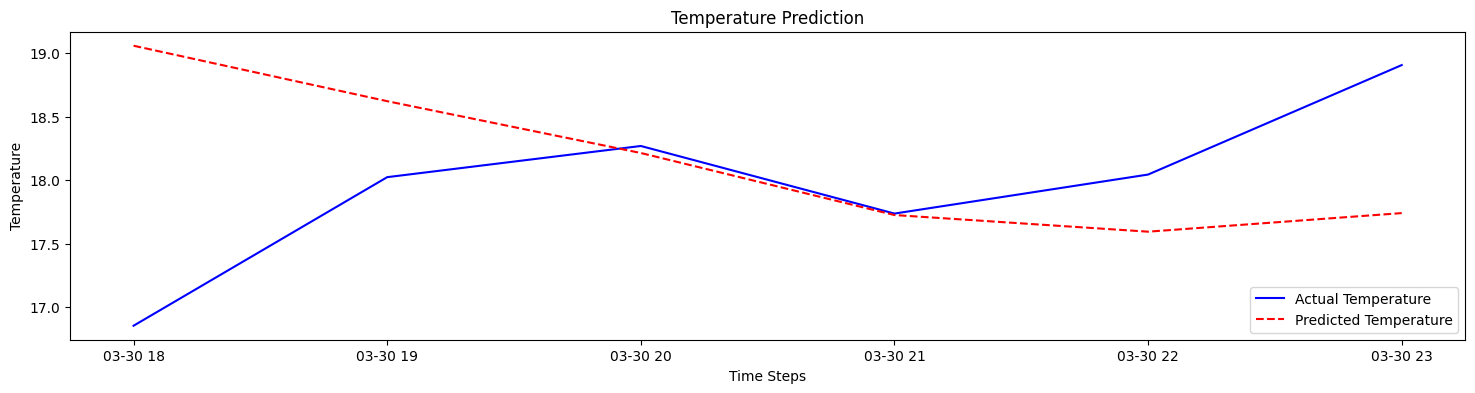

In [362]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-6:], multi_y_test[-1], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-6:], multi_predictions_48hr_6lead[-1], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

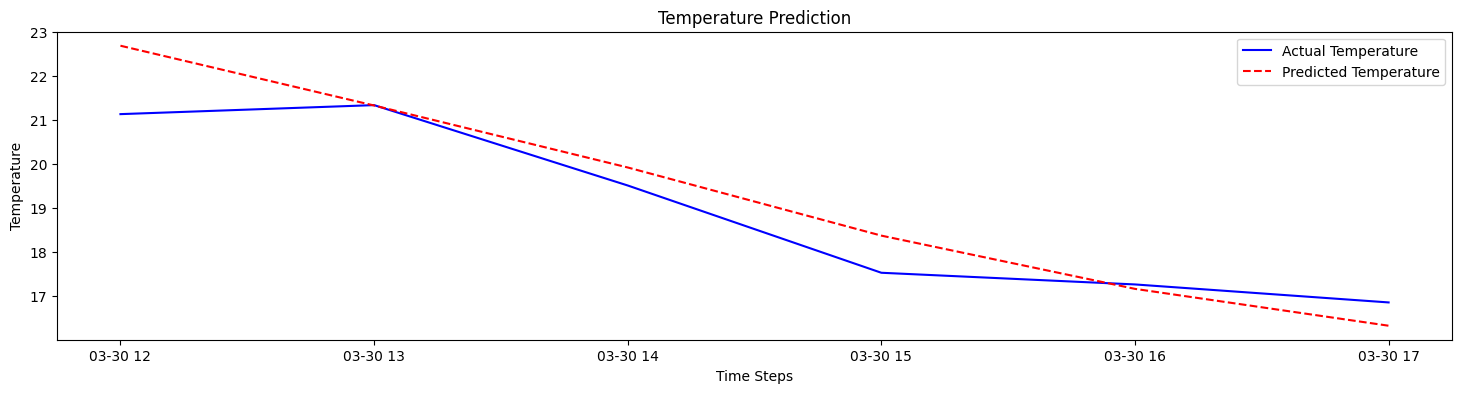

In [363]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-12:-6], multi_y_test[-6], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-12:-6], multi_predictions_48hr_6lead[-6], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

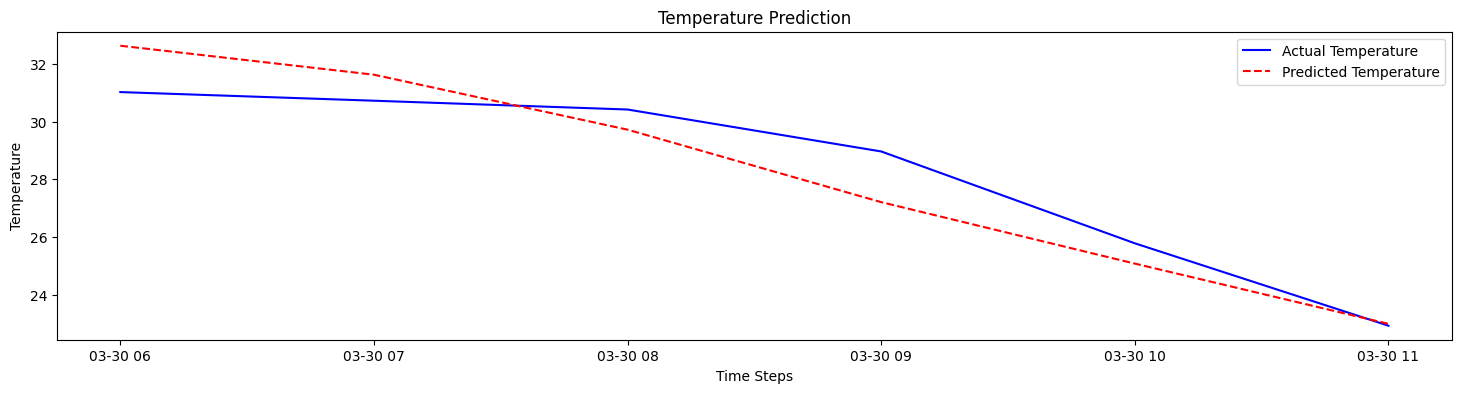

In [364]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-18:-12], multi_y_test[-12], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-18:-12], multi_predictions_48hr_6lead[-12], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()